##Setup

In [ ]:
# Set up optical-rl-gym package
import os
#Navigate to the correct working directory
while os.getcwd()!='/content':
  if os.getcwd()!='/':
    %cd ..
  else:
    %cd '/content'

!git clone https://github.com/Yiheng-Zhang259/XRL_MultiBand.git
%cd XRL_MultiBand/optical-rl-gym
!pip install -e .

In [ ]:
# Alternative: Upload from local device
from google.colab import files
uploaded=files.upload()
# Unzip the file
from zipfile import ZipFile
filepath='/content/XRL_MultiBand.zip'
with ZipFile(filepath,'r') as zip:
  zip.extractall()
  print('Done')
%cd XRL_MultiBand/optical-rl-gym
!pip install -e .

In [ ]:
# Check working directory
import os
print(os.getcwd())

/content/XRL_MultiBand/optical-rl-gym


In [ ]:
# Cell to change directory to /content
while os.getcwd()!='/content':
  if os.getcwd()!='/':
    %cd ..
  else:
    %cd '/content'

/content/XRL_MultiBand
/content


In [ ]:
# Create directory to store results
os.mkdir('/content/Results')

In [ ]:
# Test installation
import optical_rl_gym

In [ ]:
# Set up other packages relevant to the project
!pip install "stable-baselines3"
#!pip install tensorflow-gpu==1.15
#!pip install "gym==0.19.0" # Install old version of gym

In [ ]:
# Upload other files from my device to Colab
from google.colab import files
uploaded=files.upload()
# Unzip the file
from zipfile import ZipFile
filepath='/content/ProjectFiles.zip'
with ZipFile(filepath,'r') as zip:
  zip.extractall()
  print('Done')

In [ ]:
# Download the zipped folder to my device
!zip -r DQN_results.zip /content/XRL_MultiBand/DQN_results/German/CLSE/4000/tmp6_optuna/

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Import modules
import os
import gym
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)
from IPython.display import clear_output

from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
import time
%matplotlib inline

##Train and test a new topology German

In [ ]:
# run CLSE_create_topology.py file
!python XRL_MultiBand/optical-rl-gym/examples/CLSE_create_topology.py

In [ ]:
# run CLS_create_topology.py
!python XRL_MultiBand/optical-rl-gym/examples/CLS_create_topology.py

In [ ]:
# run CL_create_topology.py
!python XRL_MultiBand/optical-rl-gym/examples/CL_create_topology.py

In [ ]:
# run create_topology_rmsa.py
!python XRL_MultiBand/optical-rl-gym/examples/create_topology_rmsa.py

In [ ]:
# Draw the German topology graph
with open('/content/XRL_MultiBand/optical-rl-gym/examples/topologies/German_5-paths_CL.h5', 'rb') as f:
  topology=pickle.load(f)
  G=nx.Graph(topology)
  pos=nx.spring_layout(G)
  nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
  edge_labels=nx.get_edge_attributes(G, 'length')
  formatted_edge_labels={(elem[0], elem[1]): edge_labels[elem] for elem in edge_labels}
  nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_edge_labels, font_color='blue')
  #plt.show()
  #plt.savefig('/content/Results/German_topology_graph.png')

In [ ]:
# create an array of node_request_probabilities corresponding to the number of nodes in topology
# equal probability
a=np.ones(17)/17
print(a)

# random probability
a=np.random.random(17)
a/=a.sum()
print(a)

In [ ]:
# train the DQN agent in CLSE NSFNET topology at 4000 erlang
!python XRL_MultiBand/DQN.py

In [ ]:
# test the DQN agent at several traffic loads
!python XRL_MultiBand/DQNtest.py

##Heuristic for MultiBand RSA

In [ ]:
# loading the topology binary file containing the graph and the k-shortest paths

topology_name = 'German'
k_paths = 5
with open(f'/content/XRL_MultiBand/optical-rl-gym/examples/topologies/German_5-paths_C.h5', 'rb') as f:
    topology = pickle.load(f)

node_request_probabilities = np.ones(17)/17


# Training
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                 # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("Num timesteps: {} - ".format(self.num_timesteps),end="")
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))
                  # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model to {}".format(self.save_path))
                        self.model.save(self.save_path)
                if self.verbose > 0:
                    clear_output(wait=True)

        return True

load = 4000
holding_time = 400

log_dir = "/content/XRL_MultiBand/Heuristic_results/German/C/{}/tmp1/".format(load)
os.makedirs(log_dir, exist_ok=True)
callback = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir)
env_args = dict(topology=topology, seed=10, allow_rejection=False,
                 mean_service_holding_time=holding_time, episode_length=50, j=1, node_request_probabilities=node_request_probabilities)
training_env = gym.make('DeepRMSAKSP-v0', **env_args)

training_env = Monitor(training_env, log_dir + '100ktraining', info_keywords=('episode_service_blocking_rate','episode_bit_rate_blocking_rate'))
policy_kwargs = {'net_arch': [128] * 4}
model = DQN('MlpPolicy', training_env, verbose=0, tensorboard_log="/content/tb/German_CL_4000/DQN-DeepRMSAKSP-v0/", gamma=.95, policy_kwargs=policy_kwargs,
             learning_rate=10e-5)
env_args['seed'] = env_args['seed'] + 1
  

a = model.learn(total_timesteps=10000, callback=callback)
model.save("/content/XRL_MultiBand/Heuristic_results/German/C/{}/tmp1/best".format(load))

# Testing
rewards=[]
for ht in [50, 100, 200, 400, 600, 800, 1000, 1200]:

  env_args = dict(topology=topology, seed=11, allow_rejection=False,
          mean_service_holding_time=ht, mean_service_inter_arrival_time=0.1, episode_length=50, j=1, node_request_probabilities=node_request_probabilities)

  testing_env = gym.make('DeepRMSAKSP-v0', **env_args)

  # Logs will be saved in log_dir/monitor.csv
  testing_env = Monitor(testing_env, log_dir + '100ktesting', info_keywords=('episode_service_blocking_rate','episode_bit_rate_blocking_rate'))
  
  # Evaluate the trained agent
  start = time.time()
  mean_rewardD, std_rewardD = evaluate_policy(model, testing_env, n_eval_episodes=1000)
  end = time.time()
  print("Time required: ", (end-start))
  print(f"mean_rewardbest:{mean_rewardD:.2f} +/- {std_rewardD:.2f}")
  rewards.append(mean_rewardD)

# save the reward data
with open("German_C_heuristic_testing", "wb") as fp:
    pickle.dump(rewards, fp)

In [ ]:
# Convert mean_reward to service blocking probability
def reward_to_blocking(reward_array, positive=1, negative=-1):
  num_blocked = (50*positive-reward_array)/(positive-negative)
  return num_blocked/50

In [ ]:
# Load the data of DQN agent and heuristic
with open('German_C_heuristic_testing', 'rb') as f:
  Heuristic_C_reward=np.asarray(pickle.load(f))
with open('German_CL_heuristic_testing', 'rb') as f:
  Heuristic_CL_reward=np.asarray(pickle.load(f))
with open('German_CLS_heuristic_testing', 'rb') as f:
  Heuristic_CLS_reward=np.asarray(pickle.load(f))
with open('German_CLSE_heuristic_testing', 'rb') as f:
  Heuristic_CLSE_reward=np.asarray(pickle.load(f))
Heuristic_C=reward_to_blocking(Heuristic_C_reward)
Heuristic_CL=reward_to_blocking(Heuristic_CL_reward)
Heuristic_CLS=reward_to_blocking(Heuristic_CLS_reward)
Heuristic_CLSE=reward_to_blocking(Heuristic_CLSE_reward)

with open('German_C_100k_testing', 'rb') as f:
  DQN_C_reward=np.asarray(pickle.load(f))
with open('German_CL_100k_testing', 'rb') as f:
  DQN_CL_reward=np.asarray(pickle.load(f))
with open('German_CLS_100k_testing', 'rb') as f:
  DQN_CLS_reward=np.asarray(pickle.load(f))
with open('German_CLSE_100k_testing', 'rb') as f:
  DQN_CLSE_reward=np.asarray(pickle.load(f))
DQN_C=reward_to_blocking(DQN_C_reward)
DQN_CL=reward_to_blocking(DQN_CL_reward)
DQN_CLS=reward_to_blocking(DQN_CLS_reward)
DQN_CLSE=reward_to_blocking(DQN_CLSE_reward)

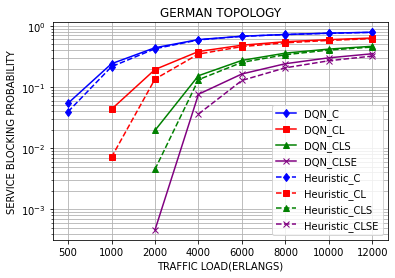

In [ ]:
# Plot the performance of DQN agent and Heuristic
load=np.array([1,2,3,4,5,6,7,8]) #allow equal spacing on x-axis
labels=['500', '1000', '2000', '4000', '6000', '8000', '10000', '12000']
plt.semilogy(load, DQN_C, color='blue', marker='d')
plt.semilogy(load[1:8], DQN_CL[1:8], color='red', marker='s')
plt.semilogy(load[2:8], DQN_CLS[2:8], color='green', marker='^')
plt.semilogy(load[2:8], DQN_CLSE[2:8], color='purple', marker='x')
plt.semilogy(load, Heuristic_C, color='blue', marker='d', linestyle='dashed')
plt.semilogy(load[1:8], Heuristic_CL[1:8], color='red', marker='s', linestyle='dashed')
plt.semilogy(load[2:8], Heuristic_CLS[2:8], color='green', marker='^', linestyle='dashed')
plt.semilogy(load[3:8], Heuristic_CLSE[3:8], color='purple', marker='x', linestyle='dashed')
plt.xticks(load, labels)
plt.grid(True, which='both')
plt.legend(['DQN_C','DQN_CL','DQN_CLS','DQN_CLSE','Heuristic_C','Heuristic_CL','Heuristic_CLS','Heuristic_CLSE'], loc='best')
plt.title('GERMAN TOPOLOGY')
plt.xlabel('TRAFFIC LOAD(ERLANGS)')
plt.ylabel('SERVICE BLOCKING PROBABILITY')
#plt.savefig('German_Topology_new.png', facecolor='white')
plt.show()

##Reward Function Design

In [ ]:
# The new reward function based on sepctrum fragmentation is implemented in 'DeepRMSA-v2'

topology_name = 'German'
k_paths = 5
with open(f'/content/XRL_MultiBand/optical-rl-gym/examples/topologies/German_5-paths_CLSE.h5', 'rb') as f:
    topology = pickle.load(f)

node_request_probabilities = np.ones(17)/17


# Training
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                 # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("Num timesteps: {} - ".format(self.num_timesteps),end="")
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))
                  # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model to {}".format(self.save_path))
                        self.model.save(self.save_path)
                if self.verbose > 0:
                    clear_output(wait=True)

        return True

load = 4000
holding_time = 400

log_dir = "/content/XRL_MultiBand/DQN_results/German/CLSE/{}/tmp5_NewReward/".format(load)
os.makedirs(log_dir, exist_ok=True)
callback = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir)
env_args = dict(topology=topology, seed=10, allow_rejection=False,
                 mean_service_holding_time=holding_time, episode_length=50, j=1, node_request_probabilities=node_request_probabilities)
training_env = gym.make('DeepRMSA-v2', **env_args)

training_env = Monitor(training_env, log_dir + '100ktraining', info_keywords=('episode_service_blocking_rate','episode_bit_rate_blocking_rate'))
policy_kwargs = {'net_arch': [128] * 4}
model = DQN('MlpPolicy', training_env, verbose=0, tensorboard_log="/content/tb/German_CL_4000/DQN-DeepRMSAKSP-v0/", gamma=.95, policy_kwargs=policy_kwargs,
             learning_rate=10e-5)
model.learn(total_timesteps=100000, callback=callback)
model.save("/content/XRL_MultiBand/DQN_results/German/CLSE/{}/tmp5_NewReward/best".format(load))

In [ ]:
topology_name = 'German'
k_paths = 5
with open(f"/content/XRL_MultiBand/optical-rl-gym/examples/topologies/German_5-paths_CLSE.h5", 'rb') as f:
    topology = pickle.load(f)

# change number of nodes according to topology
node_request_probabilities = np.ones(17)/17

# list to store the training results
rewards=[]

for ht in [50, 100, 200, 400, 600, 800, 1000, 1200]:
    env_args = dict(topology=topology, seed=11, allow_rejection=False,
                    mean_service_holding_time=ht, mean_service_inter_arrival_time=0.1, episode_length=50, j=1, node_request_probabilities=node_request_probabilities)
    testing_env = gym.make('DeepRMSA-v0', **env_args)
    # DQN model is bypassed
    model = DQN.load("/content/XRL_MultiBand/DQN_results/German/CLSE/4000/tmp5_NewReward/best.zip")
    # Evaluate the agent
    start = time.time()
    mean_rewardD, std_rewardD = evaluate_policy(model, testing_env, n_eval_episodes=1000)
    end = time.time()
    print("Time required: ", (end-start))
    print(f"mean_rewardbest:{mean_rewardD:.2f} +/- {std_rewardD:.2f}")
    rewards.append(mean_rewardD)

#save the reward data
with open("German_CLSE_100k_testing", "wb") as fp:
    pickle.dump(rewards, fp)

In [ ]:
with open('German_CLSE_heuristic_testing', 'rb') as f:
  Heuristic_CLSE_reward=np.asarray(pickle.load(f))
Heuristic_CLSE=reward_to_blocking(Heuristic_CLSE_reward)
with open('German_CLSE_100k_testing', 'rb') as f:
  DQN_CLSE_reward=np.asarray(pickle.load(f))
DQN_CLSE=reward_to_blocking(DQN_CLSE_reward)

In [ ]:
with open('German_CLSE_100k_testing', 'rb') as f:
  DQN_CLSE_reward=np.asarray(pickle.load(f))
DQN_CLSE_new=reward_to_blocking(DQN_CLSE_reward)

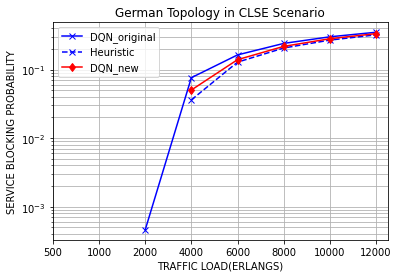

In [ ]:
load=np.array([1,2,3,4,5,6,7,8]) #allow equal spacing on x-axis
labels=['500', '1000', '2000', '4000', '6000', '8000', '10000', '12000']
plt.semilogy(load[2:8], DQN_CLSE[2:8], color='blue', marker='x')
plt.semilogy(load[3:8], Heuristic_CLSE[3:8], color='blue', marker='x', linestyle='dashed')
plt.semilogy(load[3:8], DQN_CLSE_new[3:8], color='red', marker='d')
plt.xticks(load, labels)
plt.grid(True, which='both')
plt.legend(['DQN_original','Heuristic','DQN_new'], loc='best')
plt.title('German Topology in CLSE Scenario')
plt.xlabel('TRAFFIC LOAD(ERLANGS)')
plt.ylabel('SERVICE BLOCKING PROBABILITY')
plt.savefig('New_Reward_Function.png', facecolor='white')
plt.show()

##Optuna Hyperparameter Tuning

In [ ]:
!pip install optuna
!pip install -U kaleido

In [ ]:
import optuna
import kaleido
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                 # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("Num timesteps: {} - ".format(self.num_timesteps),end="")
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))
                  # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model to {}".format(self.save_path))
                        self.model.save(self.save_path)
                if self.verbose > 0:
                    clear_output(wait=True)

        return True

In [ ]:
# Specify hyperparameters of DQN being optimized
def optimize_dqn(trial):
  gamma=trial.suggest_float('gamma', 0.8, 0.9999)
  exploration_fraction=trial.suggest_float('exploration_fraction', 0.05, 0.3)
  learning_rate=trial.suggest_float('learning_rate', 1e-6, 1e-4)
  batch_size=trial.suggest_categorical('batch_size', [32, 64, 128, 256])
  buffer_size=trial.suggest_categorical('buffer_size', [int(1e4), int(1e5), int(1e6), int(1e7)])
  tau=trial.suggest_float('tau', 0.01, 1)

  return {'gamma': gamma,
      'exploration_fraction': exploration_fraction,
      'learning_rate': learning_rate,
      'batch_size': batch_size,
      'buffer_size': buffer_size,
      'tau': tau}

In [ ]:
def objective(trial):
  try:
    hyperparameters = optimize_dqn(trial)
    k_paths = 5
    with open(f'/content/XRL_MultiBand/optical-rl-gym/examples/topologies/German_5-paths_CLSE.h5', 'rb') as f:
      topology = pickle.load(f)
    topology_name = 'German'
    node_request_probabilities = np.ones(17)/17
    load = 4000
    holding_time = 400

    log_dir = "/content/XRL_MultiBand/DQN_results/Optuna/German/{}/tmp1/".format(load)
    os.makedirs(log_dir, exist_ok=True)
    callback = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir)
    env_args = dict(topology=topology, seed=10, allow_rejection=False,
                 mean_service_holding_time=holding_time, episode_length=50, j=1, node_request_probabilities=node_request_probabilities)
    training_env = gym.make('DeepRMSA-v0', **env_args)
    training_env = Monitor(training_env, log_dir + '100ktraining', info_keywords=('episode_service_blocking_rate','episode_bit_rate_blocking_rate'))

    # Use hyperparamters from optuna
    policy_kwargs = {'net_arch': [128] * 4}
    model = DQN('MlpPolicy', training_env, verbose=0, tensorboard_log="/content/tb/Optuna/German_DQN/", policy_kwargs=policy_kwargs, **hyperparameters)
    model.learn(total_timesteps=100000, callback=callback)

    testing_env = gym.make('DeepRMSA-v0', **env_args)
    testing_env = Monitor(testing_env, log_dir + '100ktesting', info_keywords=('episode_service_blocking_rate','episode_bit_rate_blocking_rate'))

    mean_reward, std_reward = evaluate_policy(model, testing_env, n_eval_episodes=1000)

    model.save("/content/XRL_MultiBand/DQN_results/Optuna/German/models/tmp1/trial_{}_best" .format(trial.number))

    return mean_reward

  # return a huge negative reward when there is error
  except Exception as e:
    return -1000

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:')
print(study.best_params)
print('Best trial:')
print(study.best_trial)

figure1=plot_parallel_coordinate(study)
figure2=plot_param_importances(study)
figure3=plot_optimization_history(study)
figure1.write_image(file='/content/Results/Figure1.png', format='png')
figure1.show()
figure2.write_image(file='/content/Results/Figure2.png', format='png')
figure2.show()
figure3.write_image(file='/content/Results/Figure3.png', format='png')
figure3.show()

##Training with new hyperparameters
New hyperparameters are gamma=0.869, exploration_fraction=0.105, learning_rate=9.947e-5, batch_size=32, buffer_size=1e4, tau=0.181

In [ ]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                 # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("Num timesteps: {} - ".format(self.num_timesteps),end="")
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))
                  # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model to {}".format(self.save_path))
                        self.model.save(self.save_path)
                if self.verbose > 0:
                    clear_output(wait=True)

        return True

        # Create log dir
load = [4000]
holding_time = [400]
for i, j in zip(load, holding_time):
  log_dir = "/content/XRL_MultiBand/DQN_results/German/CLSE/{}/tmp6_optuna/".format(i)
  os.makedirs(log_dir, exist_ok=True)
  callback = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir)
  
  
  topology_name = 'German'
  k_paths = 5
  with open(f"/content/XRL_MultiBand/optical-rl-gym/examples/topologies/German_5-paths_CLSE.h5", 'rb') as f:
      topology = pickle.load(f)
  
  node_request_probabilities = np.ones(17)/17
  env_args = dict(topology=topology, seed=10, allow_rejection=False,
                 mean_service_holding_time=j, episode_length=50, j=1, node_request_probabilities=node_request_probabilities)
  training_env = gym.make('DeepRMSA-v2', **env_args)
  
  #print(training_env.action_space.n)
  # Logs will be saved in log_dir/monitor.csv
  training_env = Monitor(training_env, log_dir + '100ktraining', info_keywords=('episode_service_blocking_rate','episode_bit_rate_blocking_rate'))
  # kwargs = {'double_q': True, 'prioritized_replay': True, 'policy_kwargs': dict(dueling=True)} # set of parameters for testing
  policy_kwargs = {'net_arch': [128] * 4 }
  # Set the new DQN parameters
  new_para = {'gamma': 0.869, 'exploration_fraction': 0.105, 'learning_rate': 9.947e-5, 'batch_size': 32, 'buffer_size': int(1e4), 'tau': 0.181}
  model = DQN('MlpPolicy', training_env, verbose=0, tensorboard_log="/content/tb/German_CLSE_4000/DQN-DeepRMSA-v0/", policy_kwargs=policy_kwargs,
             **new_para)
 
  model.learn(total_timesteps=100000, callback=callback)
  #os.remove("/content/blockingReason4000.csv")
  model.save("/content/XRL_MultiBand/DQN_results/German/CLSE/{}/tmp6_optuna/best".format(i))

# Evaluate the trained agent
rewards=[]

for ht in [50, 100, 200, 400, 600, 800, 1000, 1200]:
    env_args = dict(topology=topology, seed=11, allow_rejection=False,
                    mean_service_holding_time=ht, mean_service_inter_arrival_time=0.1, episode_length=50, j=1, node_request_probabilities=node_request_probabilities)
    testing_env = gym.make('DeepRMSA-v0', **env_args)
    # Logs will be saved in log_dir/monitor.csv
    # Evaluate the agent
    start = time.time()
    mean_rewardD, std_rewardD = evaluate_policy(model, testing_env, n_eval_episodes=1000)
    end = time.time()
    print("Time required: ", (end-start))
    print(f"mean_rewardbest:{mean_rewardD:.2f} +/- {std_rewardD:.2f}")
    rewards.append(mean_rewardD)

#save the reward data
with open("German_CLSE_100k_testing_optuna", "wb") as fp:
    pickle.dump(rewards, fp)

Plot the blocking probability vs load graphs of the original model and model with new hyperparameters 

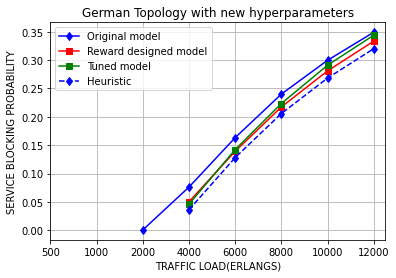

In [ ]:
with open('German_CLSE_heuristic_testing', 'rb') as f:
  Heuristic_CLSE_reward = np.asarray(pickle.load(f))
with open('German_CLSE_100k_testing', 'rb') as f:
  DQN_CLSE_reward = np.asarray(pickle.load(f))
with open('German_CLSE_100k_testing_optuna', 'rb') as f:
  DQN_CLSE_tuned_reward = np.asarray(pickle.load(f))
with open('German_CLSE_100k_testing_reward', 'rb') as f:
  DQN_CLSE_NewReward_reward = np.asarray(pickle.load(f))

Heuristic_CLSE = reward_to_blocking(Heuristic_CLSE_reward)
DQN_CLSE = reward_to_blocking(DQN_CLSE_reward)
DQN_CLSE_tuned = reward_to_blocking(DQN_CLSE_tuned_reward)
DQN_CLSE_NewReward = reward_to_blocking(DQN_CLSE_NewReward_reward)

load=np.array([1,2,3,4,5,6,7,8]) #allow equal spacing on x-axis
labels=['500', '1000', '2000', '4000', '6000', '8000', '10000', '12000']
plt.figure()
plt.plot(load[2:8], DQN_CLSE[2:8], color='blue', marker='d')
plt.plot(load[3:8], DQN_CLSE_NewReward[3:8], color='red', marker='s')
plt.plot(load[3:8], DQN_CLSE_tuned[3:8], color='green', marker='s')
plt.plot(load[3:8], Heuristic_CLSE[3:8], color='blue', marker='d', linestyle='dashed')
plt.xticks(load, labels)
plt.grid(True, which='both')
plt.legend(['Original model','Reward designed model','Tuned model','Heuristic'], loc='upper left')
plt.xlabel('TRAFFIC LOAD(ERLANGS)')
plt.ylabel('SERVICE BLOCKING PROBABILITY')
plt.title('German Topology with new hyperparameters')
plt.savefig('new_hyperparameters.png', facecolor='white')

##Explainability

In [ ]:
topology_name = 'German'
k_paths = 5
with open(f"/content/XRL_MultiBand/optical-rl-gym/examples/topologies/German_5-paths_CLSE.h5", 'rb') as f:
    topology = pickle.load(f)

# change number of nodes according to topology
node_request_probabilities = np.ones(17)/17

for ht in [50, 100, 200, 400, 600, 800, 1000, 1200]:
#for ht in [600]:
    log_dir = "/content/Results/German_CLSE_explain/tmp3/"
    env_args = dict(topology=topology, seed=11, allow_rejection=False,
                    mean_service_holding_time=ht, mean_service_inter_arrival_time=0.1, episode_length=50, j=1, node_request_probabilities=node_request_probabilities)
    testing_env = gym.make('DeepRMSA-v1', **env_args)
    testing_env = Monitor(testing_env, log_dir + '{}testing'.format(ht*10), info_keywords=('episode_service_blocking_rate','episode_bit_rate_blocking_rate',
                                              'num_C_selected','num_L_selected','num_S_selected','num_E_selected',
                                              'num_path1_selected','num_path2_selected','num_path3_selected','num_path4_selected',
                                              'num_path5_selected','total_path_length_per_episode'))
    model = DQN.load("/content/XRL_MultiBand/DQN_results/German/CLSE/4000/tmp4/best.zip")
    # Evaluate the agent
    start = time.time()
    mean_rewardD, std_rewardD = evaluate_policy(model, testing_env, n_eval_episodes=1000)
    end = time.time()
    print("Time required: ", (end-start))
    print(f"mean_rewardbest:{mean_rewardD:.2f} +/- {std_rewardD:.2f}")

In [ ]:
# Function to avoid divide by zero when total_blocked_services==0
def weird_division(n, d):
    return n / d if d else 0

percentage_C_successful = []
percentage_L_successful = []
percentage_S_successful = []
percentage_E_successful = []
probability_C_selected = []
probability_L_selected = []
probability_S_selected = []
probability_E_selected = []
percentage_path1_successful = []
percentage_path2_successful = []
percentage_path3_successful = []
percentage_path4_successful = []
percentage_path5_successful = []
probability_path1_selected = []
probability_path2_selected = []
probability_path3_selected = []
probability_path4_selected = []
probability_path5_selected = []
average_route_length = []
blocking_for_no_reason = []
blocking_slots_full = []
blocking_C = []
blocking_L = []
blocking_S = []
blocking_E = []
blocking_path1 = []
blocking_path2 = []
blocking_path3 = []
blocking_path4 = []
blocking_path5 = []
for i in [500, 1000, 2000, 4000, 6000, 8000, 10000, 12000]:
  monitortesting = pd.read_csv(f'{i}testing.monitor.csv', skiprows=[0])
  monitorblocking = pd.read_csv(f'blockingReason{i}.csv')
  total_services = monitortesting['l'].sum()
  total_blocked_services = (monitortesting['episode_service_blocking_rate']*monitortesting['l']).sum()
  total_accepted_services = total_services-total_blocked_services
  
  percentage_C_successful_per_load = monitortesting['num_C_selected'].sum()/total_accepted_services
  percentage_L_successful_per_load = monitortesting['num_L_selected'].sum()/total_accepted_services
  percentage_S_successful_per_load = monitortesting['num_S_selected'].sum()/total_accepted_services
  percentage_E_successful_per_load = monitortesting['num_E_selected'].sum()/total_accepted_services
  percentage_C_successful.append(percentage_C_successful_per_load)
  percentage_L_successful.append(percentage_L_successful_per_load)
  percentage_S_successful.append(percentage_S_successful_per_load)
  percentage_E_successful.append(percentage_E_successful_per_load)
  
  probability_C_per_load = (monitortesting['num_C_selected'].sum()+len(monitorblocking.query("Band==0")))/total_services
  probability_L_per_load = (monitortesting['num_L_selected'].sum()+len(monitorblocking.query("Band==1")))/total_services
  probability_S_per_load = (monitortesting['num_S_selected'].sum()+len(monitorblocking.query("Band==2")))/total_services
  probability_E_per_load = (monitortesting['num_E_selected'].sum()+len(monitorblocking.query("Band==3")))/total_services
  probability_C_selected.append(probability_C_per_load)
  probability_L_selected.append(probability_L_per_load)
  probability_S_selected.append(probability_S_per_load)
  probability_E_selected.append(probability_E_per_load)
  
  percentage_path1_successful_per_load = monitortesting['num_path1_selected'].sum()/total_accepted_services
  percentage_path2_successful_per_load = monitortesting['num_path2_selected'].sum()/total_accepted_services
  percentage_path3_successful_per_load = monitortesting['num_path3_selected'].sum()/total_accepted_services
  percentage_path4_successful_per_load = monitortesting['num_path4_selected'].sum()/total_accepted_services
  percentage_path5_successful_per_load = monitortesting['num_path5_selected'].sum()/total_accepted_services
  percentage_path1_successful.append(percentage_path1_successful_per_load)
  percentage_path2_successful.append(percentage_path2_successful_per_load)
  percentage_path3_successful.append(percentage_path3_successful_per_load)
  percentage_path4_successful.append(percentage_path4_successful_per_load)
  percentage_path5_successful.append(percentage_path5_successful_per_load)

  probability_path1_per_load = (monitortesting['num_path1_selected'].sum()+len(monitorblocking.query("Path==0")))/total_services
  probability_path2_per_load = (monitortesting['num_path2_selected'].sum()+len(monitorblocking.query("Path==1")))/total_services
  probability_path3_per_load = (monitortesting['num_path3_selected'].sum()+len(monitorblocking.query("Path==2")))/total_services
  probability_path4_per_load = (monitortesting['num_path4_selected'].sum()+len(monitorblocking.query("Path==3")))/total_services
  probability_path5_per_load = (monitortesting['num_path5_selected'].sum()+len(monitorblocking.query("Path==4")))/total_services
  probability_path1_selected.append(probability_path1_per_load)
  probability_path2_selected.append(probability_path2_per_load)
  probability_path3_selected.append(probability_path3_per_load)
  probability_path4_selected.append(probability_path4_per_load)
  probability_path5_selected.append(probability_path5_per_load)
  
  average_route_length_per_load = monitortesting['total_path_length_per_episode'].sum()/total_accepted_services
  average_route_length.append(average_route_length_per_load)
  
  blocking_for_no_reason_per_load = weird_division(len(monitorblocking.query("Available_Other==1")), total_blocked_services)
  blocking_slots_full_per_load = weird_division(len(monitorblocking.query("Available_Other==0")), total_blocked_services)
  blocking_for_no_reason.append(blocking_for_no_reason_per_load)
  blocking_slots_full.append(blocking_slots_full_per_load)
  
  blocking_C_per_load = weird_division(len(monitorblocking.query("Band==0")), total_blocked_services)
  blocking_L_per_load = weird_division(len(monitorblocking.query("Band==1")), total_blocked_services)
  blocking_S_per_load = weird_division(len(monitorblocking.query("Band==2")), total_blocked_services)
  blocking_E_per_load = weird_division(len(monitorblocking.query("Band==3")), total_blocked_services)
  blocking_C.append(blocking_C_per_load)
  blocking_L.append(blocking_L_per_load)
  blocking_S.append(blocking_S_per_load)
  blocking_E.append(blocking_E_per_load)
  
  blocking_path1_per_load = weird_division(len(monitorblocking.query("Path==0")), total_blocked_services)
  blocking_path2_per_load = weird_division(len(monitorblocking.query("Path==1")), total_blocked_services)
  blocking_path3_per_load = weird_division(len(monitorblocking.query("Path==2")), total_blocked_services)
  blocking_path4_per_load = weird_division(len(monitorblocking.query("Path==3")), total_blocked_services)
  blocking_path5_per_load = weird_division(len(monitorblocking.query("Path==4")), total_blocked_services)
  blocking_path1.append(blocking_path1_per_load)
  blocking_path2.append(blocking_path2_per_load)
  blocking_path3.append(blocking_path3_per_load)
  blocking_path4.append(blocking_path4_per_load)
  blocking_path5.append(blocking_path5_per_load)


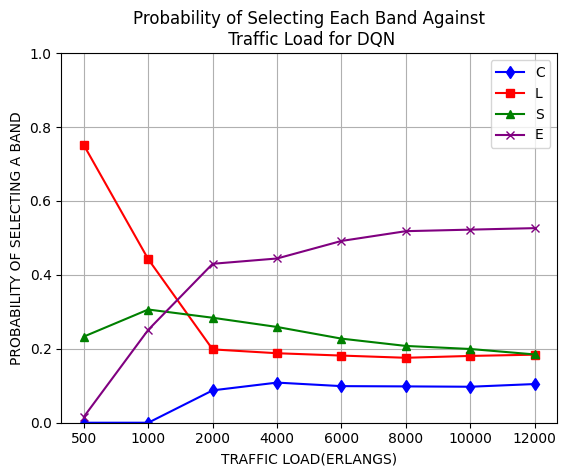

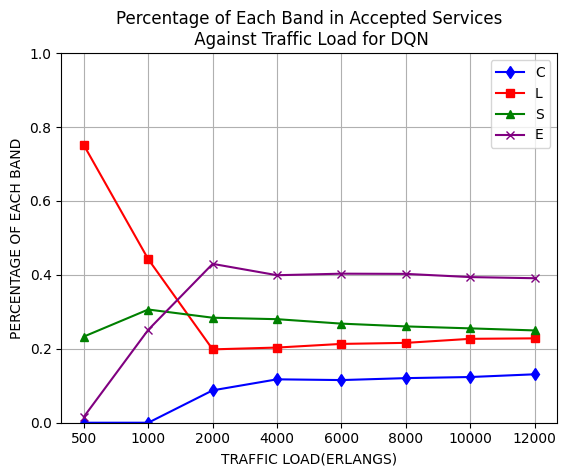

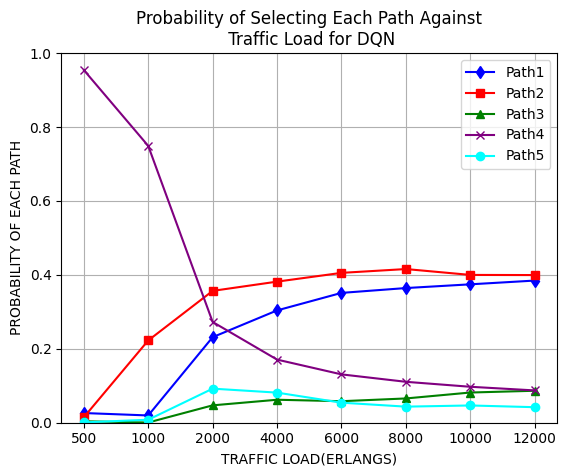

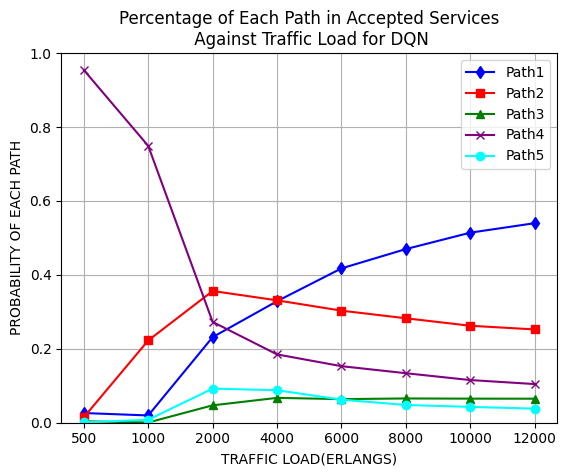

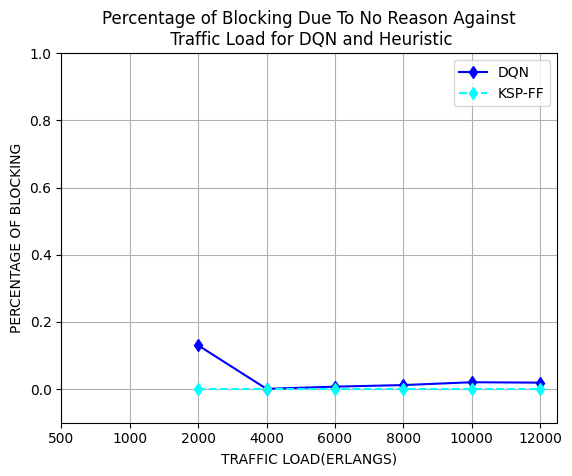

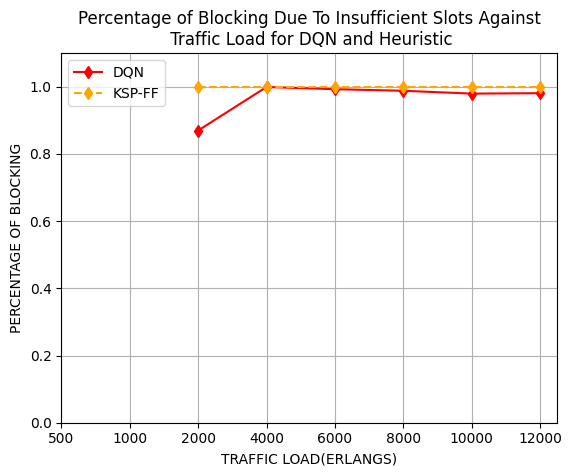

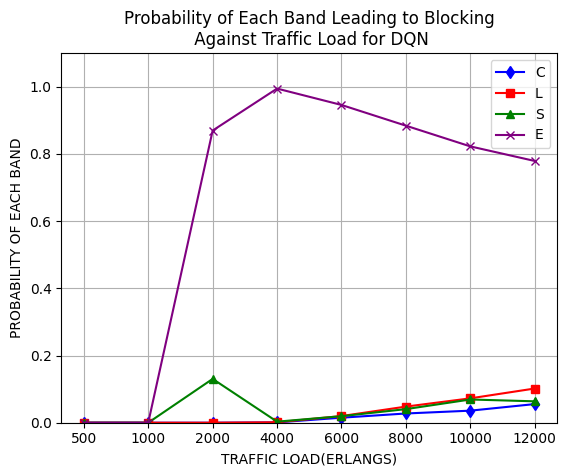

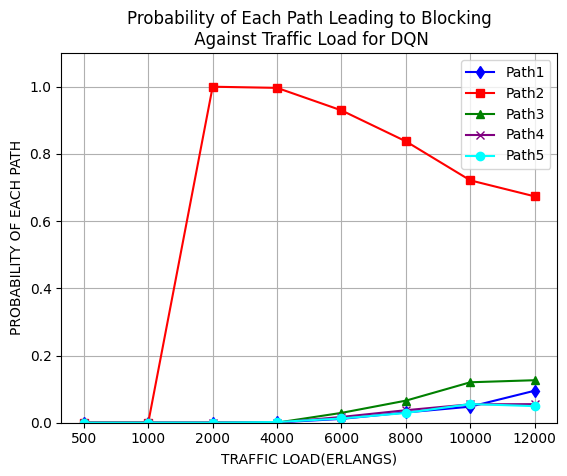

In [ ]:
# Plot the probability of DQN selecting each band against traffic load
load = np.array([1,2,3,4,5,6,7,8]) #allow equal spacing on x-axis
labels = ['500', '1000', '2000', '4000', '6000', '8000', '10000', '12000']
plt.figure()
plt.plot(load, probability_C_selected, color='blue', marker='d')
plt.plot(load, probability_L_selected, color='red', marker='s')
plt.plot(load, probability_S_selected, color='green', marker='^')
plt.plot(load, probability_E_selected, color='purple', marker='x')
plt.ylim(0,1)
plt.xticks(load, labels)
plt.grid(True, which='both')
plt.legend(['C','L','S','E'], loc='best')
plt.title('Probability of Selecting Each Band Against\n Traffic Load for DQN')
plt.xlabel('TRAFFIC LOAD(ERLANGS)')
plt.ylabel('PROBABILITY OF SELECTING A BAND')
plt.savefig('Probability_band_selected.png', facecolor='white')
plt.show()

# Plot the percentage of each band being selected in all accepted services against traffic load
plt.figure()
plt.plot(load, percentage_C_successful, color='blue', marker='d')
plt.plot(load, percentage_L_successful, color='red', marker='s')
plt.plot(load, percentage_S_successful, color='green', marker='^')
plt.plot(load, percentage_E_successful, color='purple', marker='x')
plt.ylim(0,1)
plt.xticks(load, labels)
plt.grid(True, which='both')
plt.legend(['C','L','S','E'], loc='best')
plt.title('Percentage of Each Band in Accepted Services\n Against Traffic Load for DQN')
plt.xlabel('TRAFFIC LOAD(ERLANGS)')
plt.ylabel('PERCENTAGE OF EACH BAND')
plt.savefig('Percentage_band_successful.png', facecolor='white')
plt.show()

# Plot the probability of DQN selecting each path against traffic load
plt.figure()
plt.plot(load, probability_path1_selected, color='blue', marker='d')
plt.plot(load, probability_path2_selected, color='red', marker='s')
plt.plot(load, probability_path3_selected, color='green', marker='^')
plt.plot(load, probability_path4_selected, color='purple', marker='x')
plt.plot(load, probability_path5_selected, color='cyan', marker='o')
plt.ylim(0,1)
plt.xticks(load, labels)
plt.grid(True, which='both')
plt.legend(['Path1','Path2','Path3','Path4','Path5'], loc='best')
plt.title('Probability of Selecting Each Path Against\n Traffic Load for DQN')
plt.xlabel('TRAFFIC LOAD(ERLANGS)')
plt.ylabel('PROBABILITY OF EACH PATH')
plt.savefig('Probability_path_selected.png', facecolor='white')
plt.show()

# Plot the percentage of each path being selected in all accepted services against traffic load
plt.figure()
plt.plot(load, percentage_path1_successful, color='blue', marker='d')
plt.plot(load, percentage_path2_successful, color='red', marker='s')
plt.plot(load, percentage_path3_successful, color='green', marker='^')
plt.plot(load, percentage_path4_successful, color='purple', marker='x')
plt.plot(load, percentage_path5_successful, color='cyan', marker='o')
plt.ylim(0,1)
plt.xticks(load, labels)
plt.grid(True, which='both')
plt.legend(['Path1','Path2','Path3','Path4','Path5'], loc='best')
plt.title('Percentage of Each Path in Accepted Services\n Against Traffic Load for DQN')
plt.xlabel('TRAFFIC LOAD(ERLANGS)')
plt.ylabel('PROBABILITY OF EACH PATH')
plt.savefig('Percentage_path_successful.png', facecolor='white')
plt.show()

# Plot the percentage of blocking due to no reason for DQN and heuristic
plt.figure()
plt.plot(load[2:8], blocking_for_no_reason[2:8], color='blue', marker='d')
plt.plot(load[2:8], np.zeros(6), color='cyan', marker='d', linestyle='dashed')
plt.ylim(-0.1,1)
plt.xticks(load, labels)
plt.grid(True, which='both')
plt.legend(['DQN', 'KSP-FF'], loc='best')
plt.title('Percentage of Blocking Due To No Reason Against\n Traffic Load for DQN and Heuristic')
plt.xlabel('TRAFFIC LOAD(ERLANGS)')
plt.ylabel('PERCENTAGE OF BLOCKING')
plt.savefig('Blocking_no_reason.png', facecolor='white')
plt.show()

# Plot the percentage of blocking due to insufficient slots for DQN and heuristic
plt.figure()
plt.plot(load[2:8], blocking_slots_full[2:8], color='red', marker='d')
plt.plot(load[2:8], np.ones(6), color='orange', marker='d', linestyle='dashed')
plt.ylim(0,1.1)
plt.xticks(load, labels)
plt.grid(True, which='both')
plt.legend(['DQN', 'KSP-FF'], loc='best')
plt.title('Percentage of Blocking Due To Insufficient Slots Against\n Traffic Load for DQN and Heuristic')
plt.xlabel('TRAFFIC LOAD(ERLANGS)')
plt.ylabel('PERCENTAGE OF BLOCKING')
plt.savefig('Blocking_slots_full.png', facecolor='white')
plt.show()

# Plot the probability of each band leading to blocking against traffic load
plt.figure()
plt.plot(load, blocking_C, color='blue', marker='d')
plt.plot(load, blocking_L, color='red', marker='s')
plt.plot(load, blocking_S, color='green', marker='^')
plt.plot(load, blocking_E, color='purple', marker='x')
plt.ylim(0,1.1)
plt.xticks(load, labels)
plt.grid(True, which='both')
plt.legend(['C','L','S','E'], loc='best')
plt.title('Probability of Each Band Leading to Blocking\n Against Traffic Load for DQN')
plt.xlabel('TRAFFIC LOAD(ERLANGS)')
plt.ylabel('PROBABILITY OF EACH BAND')
plt.savefig('Probability_band_blocking.png', facecolor='white')
plt.show()

# Plot the probability of each path leading to blocking against traffic load
plt.figure()
plt.plot(load, blocking_path1, color='blue', marker='d')
plt.plot(load, blocking_path2, color='red', marker='s')
plt.plot(load, blocking_path3, color='green', marker='^')
plt.plot(load, blocking_path4, color='purple', marker='x')
plt.plot(load, blocking_path5, color='cyan', marker='o')
plt.ylim(0,1.1)
plt.xticks(load, labels)
plt.grid(True, which='both')
plt.legend(['Path1','Path2','Path3','Path4','Path5'], loc='best')
plt.title('Probability of Each Path Leading to Blocking\n Against Traffic Load for DQN')
plt.xlabel('TRAFFIC LOAD(ERLANGS)')
plt.ylabel('PROBABILITY OF EACH PATH')
plt.savefig('Probability_path_blocking.png', facecolor='white')
plt.show()

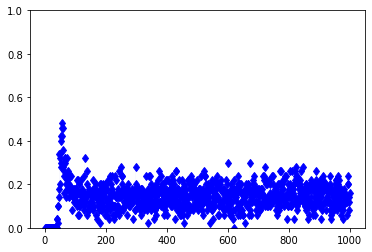

In [ ]:
# Plot the probability of DQN selecting each band against each evaluation episode at 6000 erlang
for i in [6000]:
  monitortesting = pd.read_csv(f'{i}testing.monitor.csv', skiprows=[0])
  probability_C_per_episode = monitortesting['num_C_selected']/50
  probability_L_per_episode = monitortesting['num_L_selected']/50
  probability_S_per_episode = monitortesting['num_S_selected']/50
  probability_E_per_episode = monitortesting['num_E_selected']/50
  probability_service_rejected = (50-monitortesting['num_C_selected']-monitortesting['num_L_selected']
                    -monitortesting['num_S_selected']-monitortesting['num_E_selected'])/50
  episodes = range(1, 1001)
  plt.figure()
  plt.plot(episodes, probability_C_per_episode, color='blue', marker='d', linewidth=0.01)
  #plt.plot(episodes, probability_L_per_episode, color='red', marker='s')
  #plt.plot(episodes, probability_S_per_episode, color='green', marker='^')
  #plt.plot(episodes, probability_E_per_episode, color='purple', marker='x')
  plt.ylim(0,1)
  plt.show()

In [ ]:
# Collect data from heuristic environment
topology_name = 'German'
k_paths = 5
with open(f"/content/XRL_MultiBand/optical-rl-gym/examples/topologies/German_5-paths_CLSE.h5", 'rb') as f:
    topology = pickle.load(f)

# change number of nodes according to topology
node_request_probabilities = np.ones(17)/17

for ht in [50, 100, 200, 400, 600, 800, 1000, 1200]:
    log_dir = "/content/Results/German_CLSE_explain_heuristic/tmp2/"
    env_args = dict(topology=topology, seed=11, allow_rejection=False,
                    mean_service_holding_time=ht, mean_service_inter_arrival_time=0.1, episode_length=50, j=1, node_request_probabilities=node_request_probabilities)
    testing_env = gym.make('DeepRMSAKSP-v1', **env_args)
    testing_env = Monitor(testing_env, log_dir + '{}testingHeuristic'.format(ht*10), info_keywords=('episode_service_blocking_rate','episode_bit_rate_blocking_rate',
                                              'num_C_selected','num_L_selected','num_S_selected','num_E_selected',
                                              'num_path1_selected','num_path2_selected','num_path3_selected','num_path4_selected',
                                              'num_path5_selected','total_path_length_per_episode'))
    # DQN model is bypassed
    model = DQN.load("/content/XRL_MultiBand/DQN_results/German/CLSE/4000/tmp3_optuna/best.zip")
    # Evaluate the agent
    start = time.time()
    mean_rewardD, std_rewardD = evaluate_policy(model, testing_env, n_eval_episodes=1000)
    end = time.time()
    print("Time required: ", (end-start))
    print(f"mean_rewardbest:{mean_rewardD:.2f} +/- {std_rewardD:.2f}")

In [ ]:
probability_C_selected = []
probability_L_selected = []
probability_S_selected = []
probability_E_selected = []
probability_path1_selected = []
probability_path2_selected = []
probability_path3_selected = []
probability_path4_selected = []
probability_path5_selected = []
average_route_length_heuristic = []
for i in [500, 1000, 2000, 4000, 6000, 8000, 10000, 12000]:
  monitortesting = pd.read_csv(f'{i}testingHeuristic.monitor.csv', skiprows=[0])
  total_blocked_services = (monitortesting['episode_service_blocking_rate']*monitortesting['l']).sum()
  total_accepted_services = monitortesting['l'].sum()-total_blocked_services
  
  probability_C_per_load = monitortesting['num_C_selected'].sum()/total_accepted_services
  probability_L_per_load = monitortesting['num_L_selected'].sum()/total_accepted_services
  probability_S_per_load = monitortesting['num_S_selected'].sum()/total_accepted_services
  probability_E_per_load = monitortesting['num_E_selected'].sum()/total_accepted_services
  probability_C_selected.append(probability_C_per_load)
  probability_L_selected.append(probability_L_per_load)
  probability_S_selected.append(probability_S_per_load)
  probability_E_selected.append(probability_E_per_load)

  probability_path1_per_load = monitortesting['num_path1_selected'].sum()/total_accepted_services
  probability_path2_per_load = monitortesting['num_path2_selected'].sum()/total_accepted_services
  probability_path3_per_load = monitortesting['num_path3_selected'].sum()/total_accepted_services
  probability_path4_per_load = monitortesting['num_path4_selected'].sum()/total_accepted_services
  probability_path5_per_load = monitortesting['num_path5_selected'].sum()/total_accepted_services
  probability_path1_selected.append(probability_path1_per_load)
  probability_path2_selected.append(probability_path2_per_load)
  probability_path3_selected.append(probability_path3_per_load)
  probability_path4_selected.append(probability_path4_per_load)
  probability_path5_selected.append(probability_path5_per_load)

  average_route_length_per_load = monitortesting['total_path_length_per_episode'].sum()/total_accepted_services
  average_route_length_heuristic.append(average_route_length_per_load)

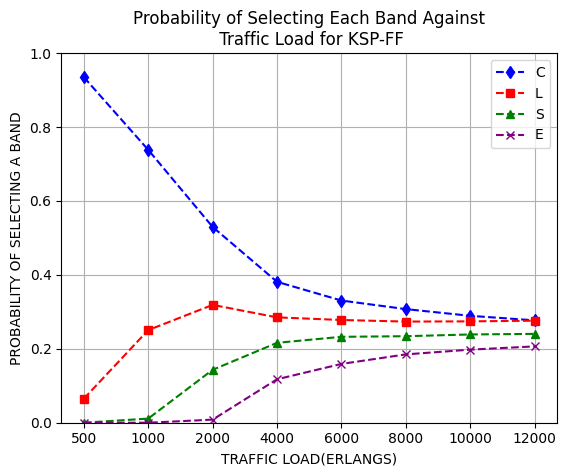

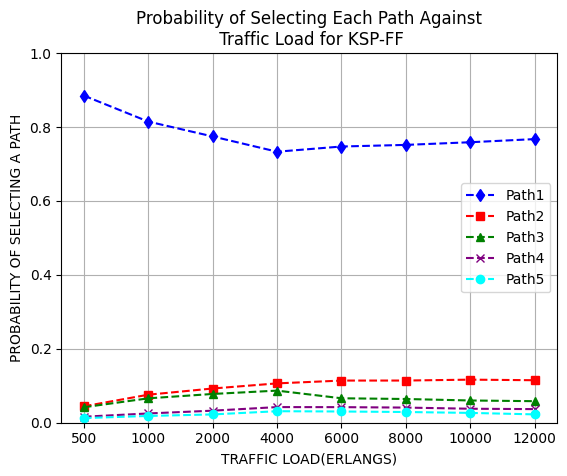

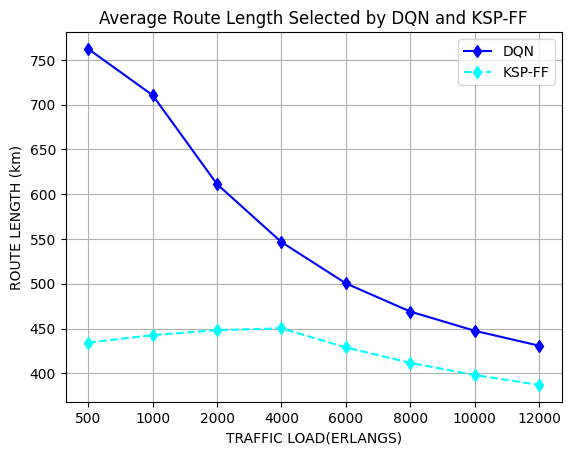

In [ ]:
# Plot the probability of heuristic selecting each band against traffic load
load = np.array([1,2,3,4,5,6,7,8]) #allow equal spacing on x-axis
labels = ['500', '1000', '2000', '4000', '6000', '8000', '10000', '12000']
plt.figure()
plt.plot(load, probability_C_selected, color='blue', marker='d', linestyle='dashed')
plt.plot(load, probability_L_selected, color='red', marker='s', linestyle='dashed')
plt.plot(load, probability_S_selected, color='green', marker='^', linestyle='dashed')
plt.plot(load, probability_E_selected, color='purple', marker='x', linestyle='dashed')
plt.ylim(0,1)
plt.xticks(load, labels)
plt.grid(True, which='both')
plt.legend(['C','L','S','E'], loc='best')
plt.title('Probability of Selecting Each Band Against\n Traffic Load for KSP-FF')
plt.xlabel('TRAFFIC LOAD(ERLANGS)')
plt.ylabel('PROBABILITY OF SELECTING A BAND')
plt.savefig('Probability_band_selected_heuristic.png', facecolor='white')
plt.show()

# Plot the probability of heuristic selecting each path against traffic load
plt.figure()
plt.plot(load, probability_path1_selected, color='blue', marker='d', linestyle='dashed')
plt.plot(load, probability_path2_selected, color='red', marker='s', linestyle='dashed')
plt.plot(load, probability_path3_selected, color='green', marker='^', linestyle='dashed')
plt.plot(load, probability_path4_selected, color='purple', marker='x', linestyle='dashed')
plt.plot(load, probability_path5_selected, color='cyan', marker='o', linestyle='dashed')
plt.ylim(0,1)
plt.xticks(load, labels)
plt.grid(True, which='both')
plt.legend(['Path1','Path2','Path3','Path4','Path5'], loc='best')
plt.title('Probability of Selecting Each Path Against\n Traffic Load for KSP-FF')
plt.xlabel('TRAFFIC LOAD(ERLANGS)')
plt.ylabel('PROBABILITY OF SELECTING A PATH')
plt.savefig('Probability_path_selected_heuristic.png', facecolor='white')
plt.show()

# Plot the average route length selected by DQN and heuristic
plt.figure()
plt.plot(load, average_route_length, color='blue', marker='d')
plt.plot(load, average_route_length_heuristic, color='cyan', marker='d', linestyle='dashed')
plt.xticks(load, labels)
plt.grid(True, which='both')
plt.legend(['DQN','KSP-FF'], loc='best')
plt.title('Average Route Length Selected by DQN and KSP-FF')
plt.xlabel('TRAFFIC LOAD(ERLANGS)')
plt.ylabel('ROUTE LENGTH (km)')
plt.savefig('Average_route_length.png', facecolor='white')
plt.show()

##DeepShap

In [ ]:
!pip install shap

In [ ]:
import shap
import torch

In [ ]:
topology_name = 'German'
k_paths = 5
with open(f"/content/XRL_MultiBand/optical-rl-gym/examples/topologies/German_5-paths_CLSE.h5", 'rb') as f:
    topology = pickle.load(f)

# change number of nodes according to topology
node_request_probabilities = np.ones(17)/17

#for ht in [50, 100, 200, 400, 600, 800, 1000, 1200]:
for ht in [800]:
    log_dir = "/content/Results/German_CLSE_explain/tmp4/"
    env_args = dict(topology=topology, seed=11, allow_rejection=False,
                    mean_service_holding_time=ht, mean_service_inter_arrival_time=0.1, episode_length=50, j=1, node_request_probabilities=node_request_probabilities)
    testing_env = gym.make('DeepRMSA-v0', **env_args)
    model = DQN.load("/content/XRL_MultiBand/DQN_results/German/CLSE/4000/tmp4/best.zip")

In [ ]:
# Function to get state log and action log
def eval(env, model):
  action_log = []
  state_log = []

  episodes = 100
  for episode in range(1, episodes+1):
    s = env.reset()
    done = False
    score = 0

    while not done:
      action, _states = model.predict(s, deterministic=True)
      s, reward, done, info = env.step(action)
      score += reward

      action_log.append(action)
      state_log.append(s)

  return np.array(state_log), np.array(action_log)

In [ ]:
state_log, action_log = eval(testing_env, model)

In [ ]:
state_log_copy = state_log.copy()
action_log_copy = action_log.copy()

###Select 500 state instances consisting of different action outputs

In [ ]:
np.unique(action_log[2000:2500])

array([ 3,  7, 11, 13, 14, 15, 16])

In [ ]:
# Choose the 500 timesteps interval of state_log
start = 2000
end = 2500
state_log = state_log_copy[start:end]
action_log = action_log_copy[start:end]

In [ ]:
explainer = shap.DeepExplainer(model.q_net, torch.FloatTensor(state_log))

In [ ]:
shap_values = explainer.shap_values(torch.FloatTensor(state_log))

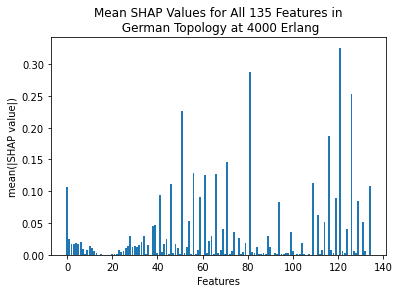

In [ ]:
# Plot the mean absolute values of the shapley values for all the 135 features
abs_shap_values = np.abs(shap_values[0])
mean_shap_values = abs_shap_values.mean(axis=0)
features = np.arange(135)
plt.figure()
plt.bar(features, mean_shap_values, width=0.8)
plt.xlabel('Features')
plt.ylabel('mean(|SHAP value|)')
plt.title('Mean SHAP Values for All 135 Features in\n German Topology at 4000 Erlang')
plt.savefig('shap_values_135_features_4000', facecolor='white')

###Processing the features into 8

In [ ]:
# Combine all 135 features in German to 8 by summing the shapley values
input_features = ['bit_rate', 'source', 'destination', 'initial index', 'number of FSUs\n of first block', 'service slots\n required', 
          'total available\n slots', 'average slots in\n available blocks']
shap_values_processed = np.zeros([shap_values[0].shape[0], 8])
shap_values_processed[:,0] = shap_values[0][:,0]
shap_values_processed[:,1] = np.sum(shap_values[0][:,1:18], axis=1)
shap_values_processed[:,2] = np.sum(shap_values[0][:,18:35], axis=1)
shap_values_processed[:,3] = np.sum(shap_values[0][:,35::5], axis=1)
shap_values_processed[:,4] = np.sum(shap_values[0][:,36::5], axis=1)
shap_values_processed[:,5] = np.sum(shap_values[0][:,37::5], axis=1)
shap_values_processed[:,6] = np.sum(shap_values[0][:,38::5], axis=1)
shap_values_processed[:,7] = np.sum(shap_values[0][:,39::5], axis=1)
abs_shap_values = np.abs(shap_values_processed)
mean_shap_values = abs_shap_values.mean(axis=0)

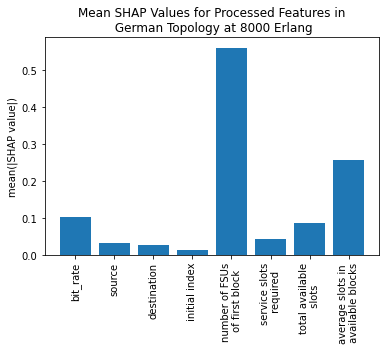

In [ ]:
# Plot shapley values for the 8 processed features
plt.figure()
features = np.arange(8)
plt.bar(features, mean_shap_values, width=0.8)
plt.xticks(features, input_features, rotation=90)
plt.ylabel('mean(|SHAP value|)')
plt.title('Mean SHAP Values for Processed Features in\n German Topology at 8000 Erlang')
plt.savefig('shap_values_8_features_8000', facecolor='white', bbox_inches="tight")

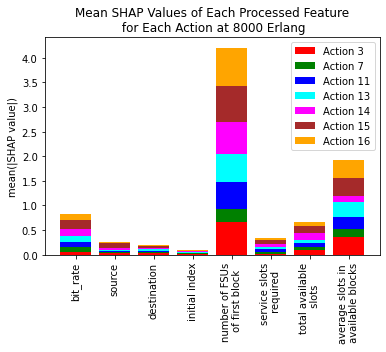

In [ ]:
# Plot the shapley values for each action taken in the 8 features

# Calculate the mean feature values for each action
means = []
unique_actions = np.unique(action_log)
for i in unique_actions:
  action_data = abs_shap_values[action_log == i, :]
  means.append(np.mean(action_data, axis=0))

# Plot a stacked bar graph
num_features = 8
num_actions = len(np.unique(action_log))
x = np.arange(num_features)
colors = ["red", "green", "blue", "cyan", "magenta", "brown", "orange", "gray", "gold"]
bottom = np.zeros(num_features)
plt.figure()
for i, j in enumerate(unique_actions):
  plt.bar(x, means[i], bottom=bottom, width=0.8, color=colors[i], label=f'Action {j}')
  bottom += means[i]
plt.xticks(x, input_features, rotation=90)
plt.legend()
plt.ylabel('mean(|SHAP value|)')
plt.title('Mean SHAP Values of Each Processed Feature\n for Each Action at 8000 Erlang')
plt.savefig('shap_values_action_8000', facecolor='white', bbox_inches='tight')

Text(0.5, 0.92, '3D Diagram of Feature-Timestep-SHAP for\n German Topology at 4000 Erlang')

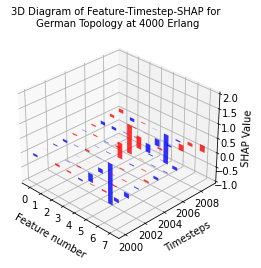

In [ ]:
# Plot 3-D Feature-time-SHAP diagram
from matplotlib.colors import ListedColormap

x = np.arange(8)
y = np.arange(2000, 2010)
z = shap_values_processed[50:60,:]

# Define the colormap with two colors
colors = ['blue', 'red']
cmap = ListedColormap(colors)

# Create a three-dimensional bar plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(z.shape[0]):
    ax.bar(x, z[i], zs=y[i], zdir='y', color=cmap(z[i] > 0), alpha=0.8, width=0.4)

# Rotate the plot
ax.view_init(elev=30, azim=-45)

ax.set_zlim(-1.0, 2)
ax.set_xticks(x)
#ax.set_xticklabels(input_features, rotation=90, fontsize=4)
ax.set_xlabel('Feature number', labelpad=0)
ax.set_ylabel('Timesteps', labelpad=0)
ax.set_zlabel('SHAP Value', labelpad=-4)

# Adjust the distance between the axis and the plot
ax.tick_params(axis='x', pad=-2)
ax.tick_params(axis='y', pad=-2)
ax.tick_params(axis='z', pad=-2)

plt.title('3D Diagram of Feature-Timestep-SHAP for\n German Topology at 4000 Erlang', fontsize=10)
#plt.savefig('3d_shap_timestep')

###Processing the features into 23

In [ ]:
# Combine all 135 features in German to 23 by summing the shapley values
input_features = ['bit_rate', 'source', 'destination']
for i in range(4):
  if i == 0:
    band = 'C'
  elif i == 1:
    band = 'L'
  elif i == 2:
    band = 'S'
  elif i == 3:
    band = 'E'
  for j in range(5):
    input_features.append('Band'+band+f'_Path{j+1}')

shap_values_processed = np.zeros([shap_values[0].shape[0], 23])
shap_values_processed[:,0] = shap_values[0][:,0]
shap_values_processed[:,1] = np.sum(shap_values[0][:,1:18], axis=1)
shap_values_processed[:,2] = np.sum(shap_values[0][:,18:35], axis=1)

for i in range(3, 23):
  shap_values_processed[:,i] = np.sum(shap_values[0][:,35+5*(i-3):40+5*(i-3)], axis=1)

abs_shap_values = np.abs(shap_values_processed)
mean_shap_values = abs_shap_values.mean(axis=0)

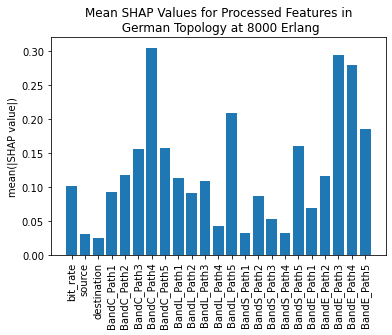

In [ ]:
# Plot shapley values for the 23 processed features
plt.figure()
features = np.arange(23)
plt.bar(features, mean_shap_values, width=0.8)
plt.xticks(features, input_features, rotation=90)
plt.ylabel('mean(|SHAP value|)')
plt.title('Mean SHAP Values for Processed Features in\n German Topology at 8000 Erlang')
plt.savefig('shap_values_23_features_8000', facecolor='white', bbox_inches='tight')